# VARIATIONAL CLASSIFIER

# A. INTRODUCTION

A variational classifier is a type of quantum machine learning algorithm that uses the principles of variational quantum algorithms (VQAs) to perform classification tasks. Here’s an overview of how it works:

1. **Parameterized Quantum Circuit (PQC):** A variational classifier leverages a parameterized quantum circuit. This circuit consists of quantum gates whose parameters can be adjusted.

2. **Classical Optimization:** The parameters of the quantum circuit are optimized using a classical optimization algorithm. This involves minimizing a cost function that measures the difference between the predicted labels (from the quantum circuit) and the true labels of the training data.

3. **Training Process:**
   - **Initialization:** The parameters of the quantum circuit are initialized, often randomly.
   - **Forward Pass:** The input data is encoded into quantum states, and the parameterized quantum circuit is applied to these states to produce an output.
   - **Measurement:** The output of the quantum circuit is measured to get the classification result.
   - **Cost Calculation:** A cost function is calculated based on the measured output and the true labels.
   - **Parameter Update:** The classical optimizer adjusts the parameters of the quantum circuit to minimize the cost function.

4. **Hybrid Approach:** Variational classifiers typically use a hybrid quantum-classical approach where quantum circuits are used for data processing and classical algorithms are used for optimization. This is because quantum computers currently have limited qubit counts and gate fidelities, making purely quantum algorithms challenging to implement for practical problems.

### Advantages and Applications

- **Quantum Advantage:** In theory, variational classifiers can exploit quantum parallelism and entanglement to provide advantages over classical classifiers, especially for certain types of data and problems.
- **Machine Learning Tasks:** Variational classifiers are used for various machine learning tasks, including image recognition, pattern recognition, and natural language processing.

### Implementation

To implement a variational classifier, the following steps are typically followed:

1. **Data Encoding:** Map classical data into quantum states.
2. **Circuit Design:** Design the structure of the parameterized quantum circuit.
3. **Cost Function:** Define a cost function that reflects the classification error.
4. **Optimization:** Use a classical optimizer to iteratively update the parameters of the quantum circuit.


After training with labeled data, these variational quantum classifiers can be used to classify new samples. The whole training/testing process is an example of supervised machine learning.

## Installs, Imports

In [3]:
pip install -q pennylane


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: /opt/.qbraid/environments/qbraid_000000/pyenv/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pennylane as qml
from pennylane import *
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer

In [47]:
import matplotlib.pyplot as plt
import numpy as np
from pennylane import numpy as np

# B. BINARY CLASSIFICATION

**Characteristics:**

- **Two Classes**: The target variable has only two possible values or classes.
- **Simple Models**: Often simpler models can be used because the decision boundary is only between two classes.
- **Evaluation Metrics**: Common metrics include accuracy, precision, recall, F1 score, and ROC-AUC.

## 1. Fitting the parity function

_In our first example a variational circuit learns the input/output behavior of a parity function. This function returns 0 for an even number of ones in a bitstring, and 1 for an odd number of ones in a bitstring._


### 1.1 Building the circuit (based on the input data)

In [53]:
# Quantum device that will run our circuits.

dev = qml.device("default.qubit", wires=4)



The full circuit is comprised of “layers” or “blocks” as elementary building blocks

In this case, one circuit layer will use four qubits/wires:
- there is an arbitrary rotation on every qubit
- a ring of CNOTs entangles each qubit with its neighbour. 

The parameters of the layer are called weights.


In [54]:
def layer(layer_weights):
    for wire in range(4):
        qml.Rot(*layer_weights[wire], wires=wire)

    for wires in ([0, 1], [1, 2], [2, 3], [3, 0]):
        qml.CNOT(wires)

One has to encode the binary inputs into the initial state of the circuit using computational basis states.

Translating the data inputs \(x\) into the circuit ensures that the resulting output is dependent on the inputs. 

In the case of the parity function, the inputs consist of bitstrings, which are encoded into the qubits' state. The quantum state \(ψ\) following the state preparation represents a computational basis state where there are 1s corresponding to the 1s in \(x\). For example, if \(x = 0101\), then \(|ψ⟩ = |0101⟩\).

The PennyLane function BasisState expects \(x\) to be a list of zeros and ones, presented as [0,1,0,1].

In [55]:
def state_preparation(x):
    qml.BasisState(x, wires=[0, 1, 2, 3])

The whole circuit is generated using the building block/layer defined above.

In [56]:
#Thr variational quantum circuit is defined  as
#this state preparation routine, followed by a 
#repetition of the layer structure.

@qml.qnode(dev)
def circuit(weights, x):
    state_preparation(x)

    for layer_weights in weights:
        layer(layer_weights)

    return qml.expval(qml.PauliZ(0))

First, we draw the circuit.

In [57]:
# circuit parameters
np.random.seed(0)

num_qubits = 4
num_layers = 2

weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)


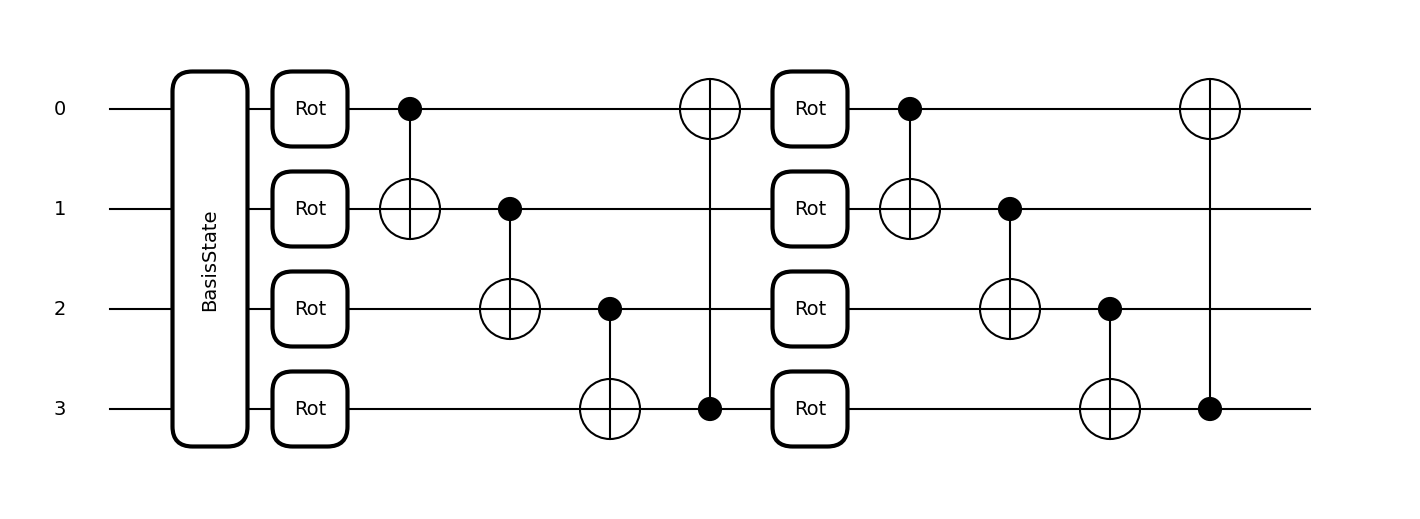

In [60]:
# function to draw the quantum circuit
def draw_circuit(weights, x):
    with qml.tape.QuantumTape() as tape:
        state_preparation(x)
        for layer_weights in weights:
            layer(layer_weights)
    
    # Draw the tape as a circuit diagram
    qml.drawer.tape_mpl(tape, style='black_white')
    plt.show()

# Example input state and weights
x = np.array([1, 0, 1, 0])
draw_circuit(weights_init, x)


We define the full model as the sum of the output of the quantum circuit and a trainable "classical" bias.

In [61]:

def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias

### 1.2 Optimization

Cost function:


The standard square loss that measures the distance between target labels and model predictions is used.

In [62]:
def square_loss(labels, predictions):
    # We use a call to qml.math.stack to allow subtracting the arrays directly
    return np.mean((labels - qml.math.stack(predictions)) ** 2)


The cost depends on the features and labels (X and Y) considered in the iteration of the optimization routine.

In [63]:
def cost(weights, bias, X, Y):
    predictions = [variational_classifier(weights, bias, x) for x in X]
    return square_loss(Y, predictions)

### 1.3 Metrics


The accuracy function measures the proportion of predictions that agree with a set of target labels.

It measures the performance of the classifier.

In [64]:
def accuracy(labels, predictions):
    acc = sum(abs(l - p) < 1e-5 for l, p in zip(labels, predictions))
    acc = acc / len(labels)
    return acc

### 1.4 Data


The data are loaded from text files, that are given.

The label Y is processed such that all 0's are converted to -1's.

In [27]:
data = np.loadtxt("variational_classifier/data/parity_train.txt", dtype=int)
X = np.array(data[:, :-1])
Y = np.array(data[:, -1])
Y = Y * 2 - 1  # shift label from {0, 1} to {-1, 1}

for x,y in zip(X, Y):
    print(f"x = {x}, y = {y}")

x = [0 0 0 1], y = 1
x = [0 0 1 0], y = 1
x = [0 1 0 0], y = 1
x = [0 1 0 1], y = -1
x = [0 1 1 0], y = -1
x = [0 1 1 1], y = 1
x = [1 0 0 0], y = 1
x = [1 0 0 1], y = -1
x = [1 0 1 1], y = 1
x = [1 1 1 1], y = -1


These are our labels Y after preprocessing:

In [50]:
print(Y)

[ 1  1  1 -1 -1  1  1 -1  1 -1]


In [30]:
print(X)

[[0 0 0 1]
 [0 0 1 0]
 [0 1 0 0]
 [0 1 0 1]
 [0 1 1 0]
 [0 1 1 1]
 [1 0 0 0]
 [1 0 0 1]
 [1 0 1 1]
 [1 1 1 1]]


### 1.5 Parameter initialization

We initialize the variables/weights randomly. 

One of the variables is used as a bias, while the rest (3) is fed into the gates of the variational circuit.

In [15]:
np.random.seed(0)
num_qubits = 4
num_layers = 2
weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

print("Weights:", weights_init)
print("Bias: ", bias_init)

Weights: [[[ 0.01764052  0.00400157  0.00978738]
  [ 0.02240893  0.01867558 -0.00977278]
  [ 0.00950088 -0.00151357 -0.00103219]
  [ 0.00410599  0.00144044  0.01454274]]

 [[ 0.00761038  0.00121675  0.00443863]
  [ 0.00333674  0.01494079 -0.00205158]
  [ 0.00313068 -0.00854096 -0.0255299 ]
  [ 0.00653619  0.00864436 -0.00742165]]]
Bias:  0.0


### 1.6 Choose and run the optimizer

In [41]:
# create an optimizer instance and choose 
# a batch size

opt = NesterovMomentumOptimizer(0.5)
batch_size = 5

Now we run the optimizer to train our model. 

In every iteration we calculate the accuracy (part of correctly classified data samples). 

The outputs of the variational classifier are our predictions in  
{
−
1
,
1
}. The sign of the output is used to distinguish between +1 and -1.

At every iteration, the weights are updated.

In [38]:
weights = weights_init
bias = bias_init
cost_list = []
iterations = []

for it in range(100):

    # Update the weights by one optimizer step,
    # using only a limited batch of data
    batch_index = np.random.randint(0, len(X), (batch_size,))
    X_batch = X[batch_index]
    Y_batch = Y[batch_index]
    weights, bias = opt.step(cost, weights, bias, X=X_batch, Y=Y_batch)

    # This is the quantum part
    predictions = [np.sign(variational_classifier(weights, bias, x)) for x in X]

    # compute accuracy
    current_cost = cost(weights, bias, X, Y)
    acc = accuracy(Y, predictions)
    cost_list.append(current_cost)
    iterations.append(it)
    
    if it % 10 == 0:
        print(f"Iter: {it+1:4d} | Cost: {current_cost:0.7f} | Accuracy: {acc:0.7f}")


Iter:    1 | Cost: 1.9962340 | Accuracy: 0.5000000
Iter:   11 | Cost: 1.3492208 | Accuracy: 0.4000000
Iter:   21 | Cost: 0.5394959 | Accuracy: 0.9000000
Iter:   31 | Cost: 0.0071664 | Accuracy: 1.0000000
Iter:   41 | Cost: 0.0005977 | Accuracy: 1.0000000
Iter:   51 | Cost: 0.0004382 | Accuracy: 1.0000000
Iter:   61 | Cost: 0.0000523 | Accuracy: 1.0000000
Iter:   71 | Cost: 0.0000115 | Accuracy: 1.0000000
Iter:   81 | Cost: 0.0000068 | Accuracy: 1.0000000
Iter:   91 | Cost: 0.0000024 | Accuracy: 1.0000000



One can see that the accuracy reaches 1 after approximately 35 iterations:

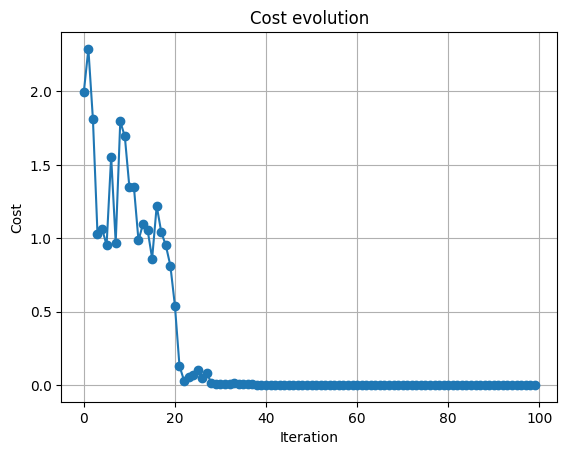

In [39]:

plt.plot(iterations, cost_list, marker='o')
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title('Cost evolution')
plt.grid(True)
plt.show()


### 1.7 Metrics: confusion matrix

To better measure the performance of our classifier beyond just the accuracy, we use a confusion matrix for binary classification.

In [40]:

Y_pred = [int(t.item()) for t in predictions]

# Print the list of values
print(Y_pred)


[1, 1, 1, -1, -1, 1, 1, -1, 1, -1]


In [41]:
pip install -q scikit-learn


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: /opt/.qbraid/environments/qbraid_000000/pyenv/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [45]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import *

In [54]:

# Compute confusion matrix
cm = confusion_matrix(Y, Y_pred, labels=[-1, 1])

# Extract confusion matrix values: flatten the confusion
# matrix to get TN, FP, FN, TP values.
TN, FP, FN, TP = cm.ravel()

# Print labeled confusion matrix
#print(cm)
print("Confusion Matrix:")
print(f"[{TP} (TP), {FN} (FN)]")
print(f"[{FP} (FP), {TN} (TN)]")
print()
# Compute performance metrics
accuracy = accuracy_score(Y, Y_pred)
sensitivity = recall_score(Y, Y_pred, pos_label=1)
specificity = recall_score(Y, Y_pred, pos_label=-1)
precision = precision_score(Y, Y_pred, pos_label=1)

# Print performance metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Sensitivity (Recall for Pos. Class):{sensitivity:.2f}")
print(f"Specificity (Recall for Neg. Class):{specificity:.2f}")
print(f"Precision: {precision:.2f}")


Confusion Matrix:
[6 (TP), 0 (FN)]
[0 (FP), 4 (TN)]

Accuracy: 1.00
Sensitivity (Recall for Pos. Class):1.00
Specificity (Recall for Neg. Class):1.00
Precision: 1.00


**Understanding the metrics:**

- Accuracy: Measures the proportion of correctly classified instances among the total instances.
- Sensitivity (Recall): Measures the proportion of actual positives that are correctly identified (True Positives / (True Positives + False Negatives)).
- Specificity: Measures the proportion of actual negatives that are correctly identified (True Negatives / (True Negatives + False Positives)).
- Precision: Measures the proportion of predicted positives that are actually positive (True Positives / (True Positives + False Positives)).
Explanation of the Code:

**confusion_matrix calculates the confusion matrix.**
- accuracy_score, recall_score, and precision_score from sklearn.metrics are used to compute various metrics.

The variational classifier learned to classify all bit strings from the training set correctly.


### 1.8 Testing the model with unseen data

Now we generalize from limited (training) data to unseen (test) data.


In [53]:
data = np.loadtxt("variational_classifier/data/parity_test.txt", dtype=int)
X_test = np.array(data[:, :-1])
Y_test = np.array(data[:, -1])
Y_test = Y_test * 2 - 1  # shift label from {0, 1} to {-1, 1}

predictions_test = [np.sign(variational_classifier(weights, bias, x)) for x in X_test]

for x,y,p in zip(X_test, Y_test, predictions_test):
    print(f"x = {x}, y = {y}, pred={p}")
print()

acc_test = accuracy(Y_test, predictions_test)
print("Accuracy on unseen data:", acc_test)

x = [0 0 0 0], y = -1, pred=-1.0
x = [0 0 1 1], y = -1, pred=-1.0
x = [1 0 1 0], y = -1, pred=-1.0
x = [1 1 1 0], y = 1, pred=1.0
x = [1 1 0 0], y = -1, pred=-1.0
x = [1 1 0 1], y = 1, pred=1.0

Accuracy on unseen data: 1.0




The quantum circuit has also learned to predict all unseen examples with an acvuracy of 1.0.


# C. MULTI-CLASS CLASSIFICATION

**Characteristics:**

- **Multiple Classes**: The target variable has more than two possible values.
- **Complex Models**: Models might need to be more complex to handle the multiple decision boundaries.
- **Evaluation Metrics**: Accuracy is commonly used, but metrics like precision, recall, and F1 score need to be extended to handle multiple classes, often using macro, micro, or weighted averages. Confusion matrices are also useful.

## 2. Iris classification

In the Iris classification task, **2-dimensional real vectors** will be encoded as amplitude vectors in quantum states (amplitude encoding). 
A variational circuit is then trained to identify classes of flowers in the Iris dataset.
The 2-dimensional vectors will be extended with some "latent dimensions", requiring 2 qubits to encide the data.

This involves another encoding strategy than the one seen in the case of the parity function (**bitstrings**).

### 2.1 Building the circuit


Quantum and classical nodes
State preparation is not as simple as when we represent a bitstring with a basis state. Every input x has to be translated into a set of angles which can get fed into a small routine for state preparation. To simplify things a bit, we will work with data from the positive subspace, so that we can ignore signs (which would require another cascade of rotations around the Z-axis).

The circuit is coded according to the scheme in Möttönen, et al. (2004), or—as presented for positive vectors only—in Schuld and Petruccione (2018). We also decomposed controlled Y-axis rotations into more basic gates, following Nielsen and Chuang (2010).

In [65]:
# Quantum device that will run our circuits.

dev = qml.device("default.qubit", wires=4)


In [66]:
def get_angles(x):
    beta0 = 2 * np.arcsin(np.sqrt(x[1] ** 2) / np.sqrt(x[0] ** 2 + x[1] ** 2 + 1e-12))
    beta1 = 2 * np.arcsin(np.sqrt(x[3] ** 2) / np.sqrt(x[2] ** 2 + x[3] ** 2 + 1e-12))
    beta2 = 2 * np.arcsin(np.linalg.norm(x[2:]) / np.linalg.norm(x))

    return np.array([beta2, -beta1 / 2, beta1 / 2, -beta0 / 2, beta0 / 2])


def state_preparation(a):
    qml.RY(a[0], wires=0)

    qml.CNOT(wires=[0, 1])
    qml.RY(a[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[2], wires=1)

    qml.PauliX(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[3], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[4], wires=1)
    qml.PauliX(wires=0)

Testing the circuit:

Computing the angles and using them for state preparation


(shortcut to state_preparation: qml.StatePrep(x, wires=[0, 1]))

In [67]:
#Let’s test if this routine actually works.

x = np.array([0.53896774, 0.79503606, 0.27826503, 0.0], requires_grad=False)
ang = get_angles(x)


@qml.qnode(dev)
def test(angles):
    state_preparation(angles)

    return qml.state()


state = test(ang)

print("x               : ", np.round(x, 6))
print("angles          : ", np.round(ang, 6))
print("amplitude vector: ", np.round(np.real(state), 6))

x               :  [0.538968 0.795036 0.278265 0.      ]
angles          :  [ 0.563975 -0.        0.       -0.975046  0.975046]
amplitude vector:  [ 0.538968  0.        0.        0.        0.795036  0.        0.
  0.        0.278265  0.        0.        0.       -0.        0.
  0.        0.      ]


Update the layer function for 2 qubits.

In [68]:
def layer(layer_weights):
    for wire in range(2):
        qml.Rot(*layer_weights[wire], wires=wire)
    qml.CNOT(wires=[0, 1])

Cost function: passing the full batch of data to the state preparation of the circuit simultaneously.

In [45]:
def cost(weights, bias, X, Y):
    # Transpose the batch of input data in order to make the indexing
    # in state_preparation work
    predictions = variational_classifier(weights, bias, X.T)
    return square_loss(Y, predictions)

### 2.2 Drawing the circuit

In [17]:
#import pennylane as qml
#import numpy as np

dev = qml.device("default.qubit", wires=2)

@qml.qnode(dev)
def circuit(a, layer_weights):
    state_preparation(a)
    layer(layer_weights)
    return qml.expval(qml.PauliZ(0))

a = np.random.random(5)
layer_weights = np.random.random((2, 3))
weights_init = layer_weights

# Draw the circuit with the prepared inputs
drawer = qml.draw(circuit)
print(drawer(a, layer_weights))



0: ──RY(0.12)─╭●───────────╭●──X────────╭●───────────╭●──X─────────Rot(0.06,0.42,0.90)─╭●─┤  <Z>
1: ───────────╰X──RY(0.76)─╰X──RY(0.12)─╰X──RY(0.64)─╰X──RY(0.63)──Rot(0.49,0.52,0.66)─╰X─┤     


In [23]:
import pennylane as qml
import numpy as np
#import mpldrawer

dev = qml.device("default.qubit", wires=2)

def state_preparation(a):
    qml.RY(a[0], wires=0)

    qml.CNOT(wires=[0, 1])
    qml.RY(a[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[2], wires=1)

    qml.PauliX(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[3], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[4], wires=1)
    qml.PauliX(wires=0)

def layer(layer_weights):
    for wire in range(2):
        qml.Rot(*layer_weights[wire], wires=wire)
    qml.CNOT(wires=[0, 1])

@qml.qnode(dev)
def circuit(a, layer_weights):
    state_preparation(a)
    layer(layer_weights)
    return qml.expval(qml.PauliZ(0))


In [27]:
#sample input
a = np.random.random(5)
layer_weights = np.random.random((2, 3))


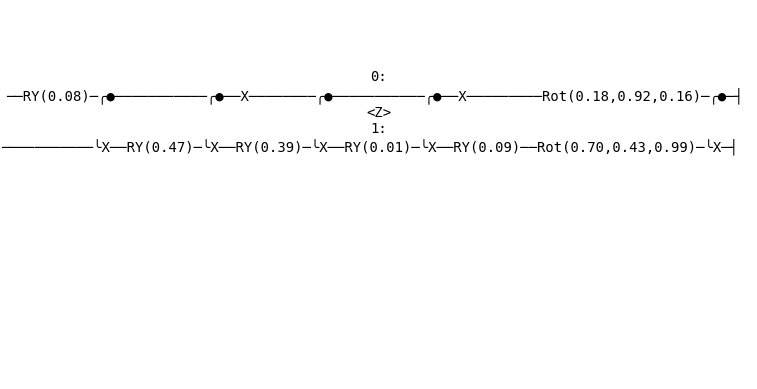

In [28]:
drawer = qml.draw(circuit, expansion_strategy="device")
circuit_text = drawer(a, layer_weights)

# Use Matplotlib to plot the circuit
fig, ax = plt.subplots()
ax.axis('off')
ax.text(0.7, 0.7, circuit_text, ha='center', va='center', wrap=True, family='monospace')
plt.show()


### 2.3 Iris dataset: loading amd preprocessing

- loading the Iris dataset

Preprocessing to encode the inputs into the amplitudes of a quantum state:

- augment the data points by two so-called “latent dimensions”: this ensures that the size of the padded data point is equal to the size of the state vector in the quantum device
- normalization of the data points (without latent dimensions, normalization erases information on vector lengths - can't distinguish classes separated by this information)


In [69]:
data = np.loadtxt("variational_classifier/data/iris_classes1and2_scaled.txt")
X = data[:, 0:2]
print(f"First X sample (original)  : {X[0]}")

# pad the vectors to size 2^2=4 with constant values
padding = np.ones((len(X), 2)) * 0.1
X_pad = np.c_[X, padding]
print(f"First X sample (padded)    : {X_pad[0]}")

# normalize each input
normalization = np.sqrt(np.sum(X_pad**2, -1))
X_norm = (X_pad.T / normalization).T
print(f"First X sample (normalized): {X_norm[0]}")

First X sample (original)  : [0.4  0.75]
First X sample (padded)    : [0.4  0.75 0.1  0.1 ]
First X sample (normalized): [0.46420708 0.87038828 0.11605177 0.11605177]


**The get_angles function translates the inputs x to rotation angles.**

These angles are our new features, renamed from X to “features”.

In [70]:
# the angles for state preparation are the features
features = np.array([get_angles(x) for x in X_norm], requires_grad=False)
print(f"First features sample      : {features[0]}")

Y = data[:, -1]

First features sample      : [ 0.32973573 -0.78539816  0.78539816 -1.080839    1.080839  ]


In [74]:
print(len(X_norm))

100


**Plotting the stages of preprocessing:**
Depending on the combination of features/dimensions (dim1, dim2) the class separation varies from good to none.

| dim1 | dim2 | separation|
|---|---|----------|
|0|1|ok|
|0|2|no|
|0|3|good|
|0|4|good|


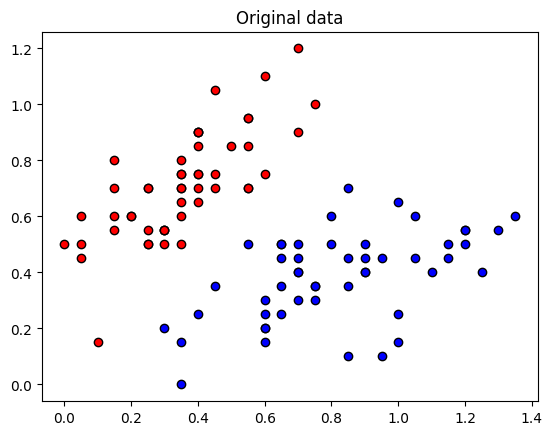

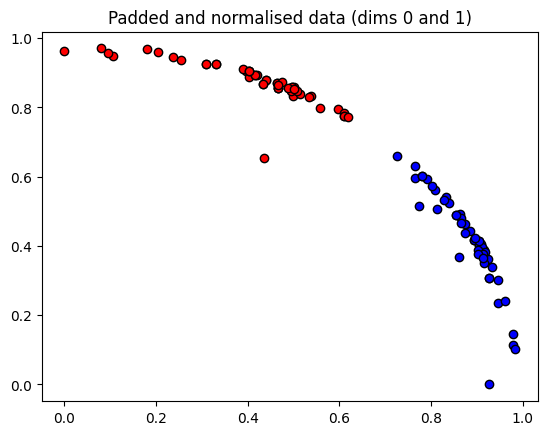

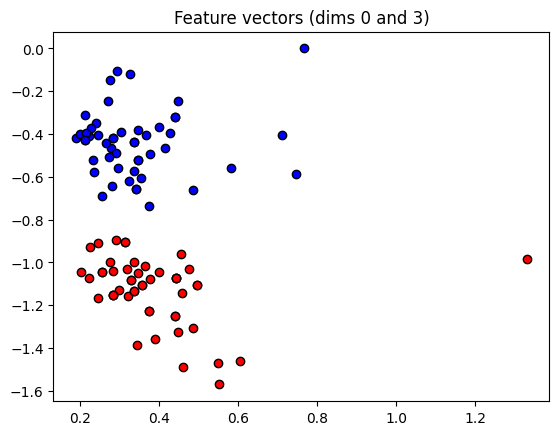

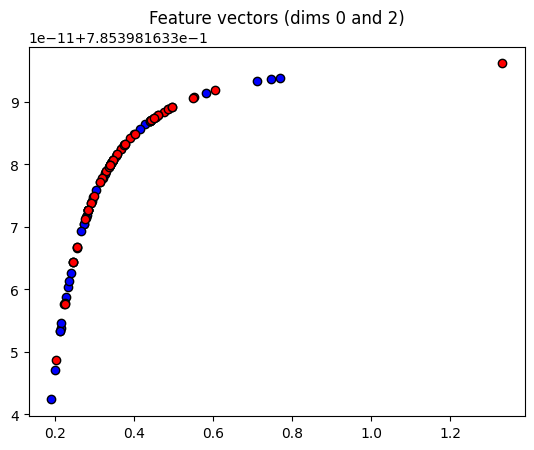

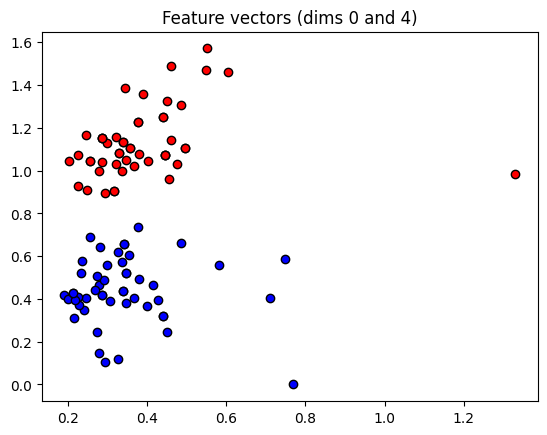

In [82]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(X[:, 0][Y == 1], X[:, 1][Y == 1], c="b", marker="o", ec="k")
plt.scatter(X[:, 0][Y == -1], X[:, 1][Y == -1], c="r", marker="o", ec="k")
plt.title("Original data")
plt.show()

plt.figure()
dim1 = 0
dim2 = 1
plt.scatter(X_norm[:, dim1][Y == 1], X_norm[:, dim2][Y == 1], c="b", marker="o", ec="k")
plt.scatter(X_norm[:, dim1][Y == -1], X_norm[:, dim2][Y == -1], c="r", marker="o", ec="k")
plt.title(f"Padded and normalised data (dims {dim1} and {dim2})")
plt.show()

plt.figure()
dim1 = 0
dim2 = 3
plt.scatter(features[:, dim1][Y == 1], features[:, dim2][Y == 1], c="b", marker="o", ec="k")
plt.scatter(features[:, dim1][Y == -1], features[:, dim2][Y == -1], c="r", marker="o", ec="k")
plt.title(f"Feature vectors (dims {dim1} and {dim2})")
plt.show()

plt.figure()
dim1 = 0
dim2 = 2
plt.scatter(features[:, dim1][Y == 1], features[:, dim2][Y == 1], c="b", marker="o", ec="k")
plt.scatter(features[:, dim1][Y == -1], features[:, dim2][Y == -1], c="r", marker="o", ec="k")
plt.title(f"Feature vectors (dims {dim1} and {dim2})")
plt.show()

plt.figure()
dim1 = 0
dim2 = 4
plt.scatter(features[:, dim1][Y == 1], features[:, dim2][Y == 1], c="b", marker="o", ec="k")
plt.scatter(features[:, dim1][Y == -1], features[:, dim2][Y == -1], c="r", marker="o", ec="k")
plt.title(f"Feature vectors (dims {dim1} and {dim2})")
plt.show()


### 2.4 Training and testing the model

Now we train our model on one set of data and test the model with unseen data to evaluate the generalization performance of the model.

#### The data is split into training and validation set.

In [24]:
np.random.seed(0)
num_data = len(Y)
num_train = int(0.75 * num_data)
index = np.random.permutation(range(num_data))
feats_train = features[index[:num_train]]
Y_train = Y[index[:num_train]]
feats_val = features[index[num_train:]]
Y_val = Y[index[num_train:]]

# We need these later for plotting
X_train = X[index[:num_train]]
X_val = X[index[num_train:]]

#### Optimization: variable initialization


In [25]:
num_qubits = 2
num_layers = 6

weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

#### Optimization: minimize cost


In [26]:
#Again we minimize the cost, using the imported optimizer.

opt = NesterovMomentumOptimizer(0.01)
batch_size = 5

# train the variational classifier
weights = weights_init
bias = bias_init
for it in range(60):
    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, num_train, (batch_size,))
    feats_train_batch = feats_train[batch_index]
    Y_train_batch = Y_train[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, feats_train_batch, Y_train_batch)

    # Compute predictions on train and validation set
    predictions_train = np.sign(variational_classifier(weights, bias, feats_train.T))
    predictions_val = np.sign(variational_classifier(weights, bias, feats_val.T))

    # Compute accuracy on train and validation set
    acc_train = accuracy(Y_train, predictions_train)
    acc_val = accuracy(Y_val, predictions_val)

    if (it + 1) % 5 == 0:
        _cost = cost(weights, bias, features, Y)
        print(
            f"Iter: {it + 1:5d} | Cost: {_cost:0.7f} | "
            f"Acc train: {acc_train:0.7f} | Acc validation: {acc_val:0.7f}"
        )

Iter:     2 | Cost: 1.6589456 | Acc train: 0.4800000 | Acc validation: 0.5600000
Iter:     4 | Cost: 1.2054273 | Acc train: 0.4933333 | Acc validation: 0.5600000
Iter:     6 | Cost: 0.9740740 | Acc train: 0.4933333 | Acc validation: 0.7200000
Iter:     8 | Cost: 0.9660872 | Acc train: 0.6400000 | Acc validation: 0.6400000
Iter:    10 | Cost: 0.9569019 | Acc train: 0.6000000 | Acc validation: 0.6000000
Iter:    12 | Cost: 0.9445863 | Acc train: 0.4933333 | Acc validation: 0.7200000
Iter:    14 | Cost: 1.0339978 | Acc train: 0.4800000 | Acc validation: 0.5600000
Iter:    16 | Cost: 1.0774217 | Acc train: 0.4933333 | Acc validation: 0.5600000
Iter:    18 | Cost: 0.9984426 | Acc train: 0.4800000 | Acc validation: 0.5600000
Iter:    20 | Cost: 0.8975279 | Acc train: 0.5600000 | Acc validation: 0.7600000
Iter:    22 | Cost: 0.8451699 | Acc train: 0.6400000 | Acc validation: 0.6400000
Iter:    24 | Cost: 0.8337489 | Acc train: 0.5600000 | Acc validation: 0.5200000
Iter:    26 | Cost: 0.783202

#### Visualization: output of the variational classifier for the first two dimensions of the Iris dataset

The variational classifier is able to distinguish between the datapoints of the two different classes, even for unseen validation data.


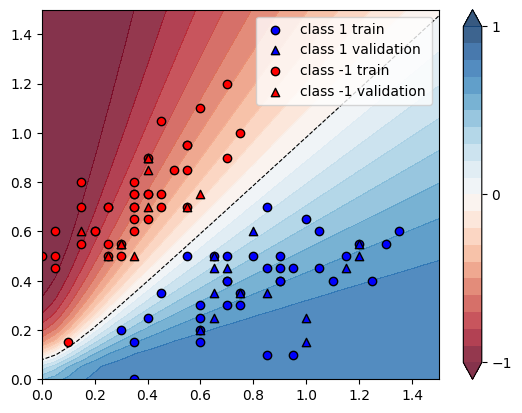

In [27]:
plt.figure()
cm = plt.cm.RdBu

# make data for decision regions
xx, yy = np.meshgrid(np.linspace(0.0, 1.5, 30), np.linspace(0.0, 1.5, 30))
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]

# preprocess grid points like data inputs above
padding = 0.1 * np.ones((len(X_grid), 2))
X_grid = np.c_[X_grid, padding]  # pad each input
normalization = np.sqrt(np.sum(X_grid**2, -1))
X_grid = (X_grid.T / normalization).T  # normalize each input
features_grid = np.array([get_angles(x) for x in X_grid])  # angles are new features
predictions_grid = variational_classifier(weights, bias, features_grid.T)
Z = np.reshape(predictions_grid, xx.shape)

# plot decision regions
levels = np.arange(-1, 1.1, 0.1)
cnt = plt.contourf(xx, yy, Z, levels=levels, cmap=cm, alpha=0.8, extend="both")
plt.contour(xx, yy, Z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,))
plt.colorbar(cnt, ticks=[-1, 0, 1])

# plot data
for color, label in zip(["b", "r"], [1, -1]):
    plot_x = X_train[:, 0][Y_train == label]
    plot_y = X_train[:, 1][Y_train == label]
    plt.scatter(plot_x, plot_y, c=color, marker="o", ec="k", label=f"class {label} train")
    plot_x = (X_val[:, 0][Y_val == label],)
    plot_y = (X_val[:, 1][Y_val == label],)
    plt.scatter(plot_x, plot_y, c=color, marker="^", ec="k", label=f"class {label} validation")

plt.legend()
plt.show()